In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, Target-Thresh: Vary threshold
No blending of hierarchy, and instead of shrinking towards the mean, low volume codes are set to NA values

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_thresh_encoder import TargetThreshEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Comparison metrics

In [9]:
metrics_base = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

In [26]:
metrics_tcenc = pd.read_csv(Path(setup.temp_path).joinpath('A02_REPORT_metrics.csv'))

## Function to get metrics

In [10]:
def get_metrics(data, threshold = 100, enc_features = ['NAICS', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetThreshEncoder(threshold = threshold) for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [11]:
count_sets = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

In [12]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for c in count_sets:
    this_pred, this_met = get_metrics(sba_loans, c, ['NAICS'])
    this_pred['c'] = c
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = c
    metrics_df = pd.concat([metrics_df, this_met])

In [13]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.679149,0.415743,0.310672,0.628204,0.346129,0.725413,1.0,5
1,test,0.722745,0.399680,0.329474,0.507910,0.342326,0.724919,1.0,10
1,test,0.730908,0.399630,0.336064,0.492852,0.343240,0.725454,1.0,20
1,test,0.693983,0.414930,0.317916,0.597158,0.345827,0.727014,1.0,50
1,test,0.689233,0.416768,0.316230,0.611031,0.345690,0.727347,1.0,100
1,test,0.673999,0.418779,0.309738,0.646307,0.346034,0.728247,1.0,200
1,test,0.663162,0.419304,0.305291,0.669233,0.347995,0.729532,1.0,500
1,test,0.635722,0.419803,0.295397,0.725235,0.348192,0.729452,1.0,1000
1,test,0.623578,0.420961,0.292143,0.752982,0.350590,0.730370,1.0,2000


In [14]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.659783,0.449008,0.336651,0.673932,0.384117,0.728273,0.0,5
0,test,0.660264,0.449110,0.336935,0.673256,0.383112,0.728365,0.0,10
0,test,0.660724,0.449961,0.337541,0.674661,0.383805,0.728587,0.0,20
0,test,0.661259,0.450504,0.338048,0.675077,0.384132,0.728849,0.0,50
0,test,0.659483,0.448981,0.336491,0.674452,0.382759,0.728253,0.0,100
0,test,0.656541,0.448488,0.334838,0.678926,0.381273,0.727429,0.0,200
0,test,0.652678,0.446612,0.332167,0.681371,0.377244,0.724080,0.0,500
0,test,0.621572,0.445100,0.318663,0.737866,0.372379,0.721684,0.0,1000
0,test,0.613429,0.442648,0.314633,0.746294,0.363523,0.716924,0.0,2000


In [15]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A10_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A10_REPORT_metrics.csv'), index=True)

## Compare Results to Standard

#### Regular randomized test

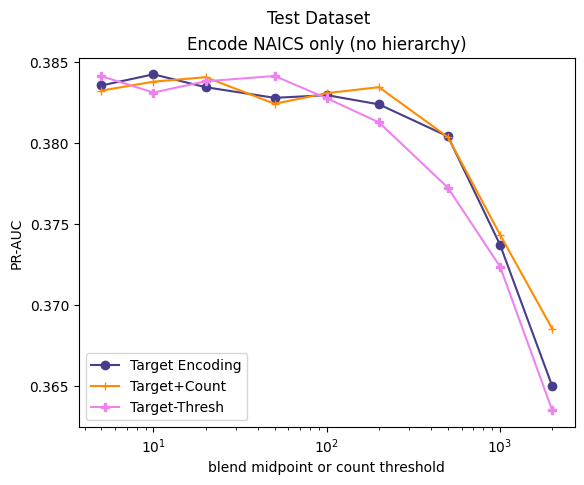

In [32]:
fig, ax = plt.subplots()
metrics_base[metrics_base['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target Encoding',color='darkslateblue', style='o-')
metrics_tcenc[metrics_tcenc['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
metrics_df[metrics_df['dset_naics_holdout'] == 0] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target-Thresh',color='violet', style='P-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blend midpoint or count threshold')
fig.suptitle('Test Dataset')
ax.set_title('Encode NAICS only (no hierarchy)')
fig.savefig(Path(setup.temp_path).joinpath('A10_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

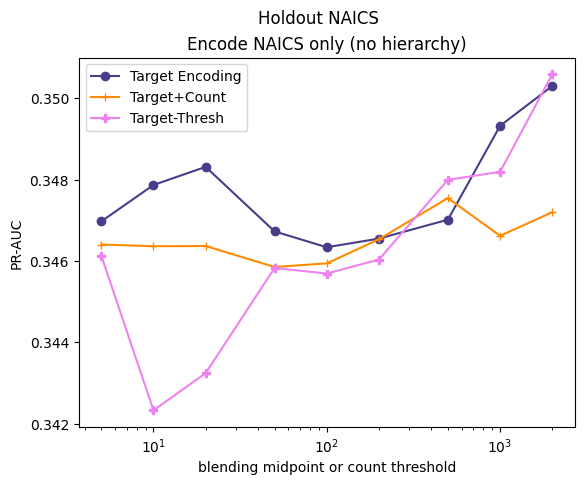

In [33]:
fig, ax = plt.subplots()
metrics_base[metrics_base['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target Encoding',color='darkslateblue', style='o-')
metrics_tcenc[metrics_tcenc['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
metrics_df[metrics_df['dset_naics_holdout'] == 1] \
    .plot(x='c', y='average_precision_score', logx=True, ax=ax, 
          label='Target-Thresh',color='violet', style='P-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('blending midpoint or count threshold')
fig.suptitle('Holdout NAICS')
ax.set_title('Encode NAICS only (no hierarchy)')
fig.savefig(Path(setup.temp_path).joinpath('A10_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

## 3-way Plot